## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## Derive Pipeline for 
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. 
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image

In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg





# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_left_afitted = [0] * 50
        self.recent_left_bfitted = [0] * 50
        self.recent_left_cfitted = [0] * 50
        self.recent_right_afitted = [0] * 50
        self.recent_right_bfitted = [0] * 50
        self.recent_right_cfitted = [0] * 50
        self.recent_fit_counter = 0
        #average x values of the fitted line over the last n iterations
        self.bestleftx = np.empty(3)
        self.bestrightx = np.empty(3)        

        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.currentleft_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])  
        self.currentright_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
        self.currentFitValidity = False
        #radius of curvature of the line in some units
        self.L_radius_of_curvature = [0] * 50
        self.R_radius_of_curvature = [0] * 50
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #array of vehicle position
        self.vehicleposition = [0] * 50
        self.center = 0
        #array of lanecurve
        self.arraycurve = [0] * 50
        #array of lanecurve
        self.currentcurve = 0
#         self.R_currentcurve = 0
        self.curveCounter = 0
        self.curveValidity = False

        
    def readbestfit(self):
        return self.bestleftx[0],self.bestleftx[1],self.bestleftx[2],self.bestrightx[0],self.bestrightx[1],self.bestrightx[2]
    
    def appendValues(self,l0,l1,l2,r0,r1,r2):
    
        if self.recent_fit_counter < 50:    
             
            self.recent_left_afitted[self.recent_fit_counter] = l0
            self.recent_left_bfitted[self.recent_fit_counter] = l1
            self.recent_left_cfitted[self.recent_fit_counter] = l2
            self.recent_right_afitted[self.recent_fit_counter] = r0
            self.recent_right_bfitted[self.recent_fit_counter] = r1
            self.recent_right_cfitted[self.recent_fit_counter] = r2            
        else:
            self.recent_fit_counter = 0  
            self.currentFitValidity = True
            self.recent_left_afitted[self.recent_fit_counter] = l0
            self.recent_left_bfitted[self.recent_fit_counter] = l1
            self.recent_left_cfitted[self.recent_fit_counter] = l2
            self.recent_right_afitted[self.recent_fit_counter] = r0
            self.recent_right_bfitted[self.recent_fit_counter] = r1
            self.recent_right_cfitted[self.recent_fit_counter] = r2 
            self.detected = True
            
        self.recent_fit_counter += 1
        
        if self.currentFitValidity == True:
            #store mean for past 50 lane pixel positions from the list
            self.bestleftx[0] = np.average(self.recent_left_afitted[-50:])
            self.bestleftx[1] = np.average(self.recent_left_bfitted[-50:])
            self.bestleftx[2] = np.average(self.recent_left_cfitted[-50:])

            self.bestrightx[0] = np.average(self.recent_right_afitted[-50:])
            self.bestrightx[1] = np.average(self.recent_right_bfitted[-50:])
            self.bestrightx[2] = np.average(self.recent_right_cfitted[-50:]) 
    def curvature(self,left,right,cent):   
        #Determine road curvature and predict left or right turn
        
        if (left + 300) > right or cent < 0.15:
            #roads does not have similar cuvature
            self.detected = False #use sliding pannel
            self.currentcurve = np.mean(self.L_radius_of_curvature[-10:])
        elif (right + 300) > left or cent > 0.30:
            self.detected = False #use sliding pannel method
            self.currentcurve = np.mean(self.R_radius_of_curvature[-10:])
        else:
            #roads have similar cuvature
            self.detected = True #use search poly method
        self.center = np.mean(self.vehicleposition[-10:])         

        
        #store last 50 curvature   
        if self.curveCounter < 50:
            self.L_radius_of_curvature[self.curveCounter] = left
            self.R_radius_of_curvature[self.curveCounter] = right
            self.vehicleposition[self.curveCounter]= cent
        else:
            self.curveCounter= 0
            self.L_radius_of_curvature[self.curveCounter] = left
            self.R_radius_of_curvature[self.curveCounter] = right
            self.vehicleposition[self.curveCounter]= cent
            self.curveValidity = True
        self.curveCounter += 1
        self.currentcurve = left
        self.center = cent

                


        
Lanetrack = Line()    

def findImgpts(images):
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corner
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)

def cal_undistort(img, objpts, imgpts):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

#  pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100),binaryform=0):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold l color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1
 
    # Threshold h color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= s_thresh[0]) & (h_channel <= s_thresh[1])] = 1

    
    if binaryform == 0:
        
        # Stack each channel
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        return color_binary
    
    elif binaryform == 1:
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        return combined_binary
    
def perspective_warp(img,img_size,src,dst):
    #src points identified using the straight line1 image given
    #dst points are identified using the image size and offset
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)


    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(ThresholdedColorBinaryImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def get_binaryWarped(image):
    offset = 100
    # returns undistorted image
    undistorted = cal_undistort(image, objpoints, imgpoints)
    #Use color transforms, gradients, etc., to create a 
    #thresholded color binary image
    ThresholdedColorBinaryImage = pipeline(undistorted,s_thresh=(180, 255), sx_thresh=(20, 100),binaryform = 0)
    # thresholded combined binary image
    ThresholdedCombinedBinaryImage = pipeline(undistorted,s_thresh=(180, 255), sx_thresh=(20, 100),binaryform = 1)
    #thresholded combined binary image
    img_size = (ThresholdedCombinedBinaryImage.shape[1], ThresholdedCombinedBinaryImage.shape[0])

    src = np.float32(
            [[707,463], #top right
             [1053,686], #bottom right
             [231,701], #bottom left
             [572,467]]) #top left


    dst = np.float32([[img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset], 
                       [offset, offset]])  

    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(ThresholdedCombinedBinaryImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    return binary_warped


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # plt.imshow(out_img)
    # # Find the peak of the left and right halves of the histogram
    # # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #######################################################################################
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
    #     print(win_y_low,win_y_high)
        #plt.plot(win_y_low,win_y_high,'ro')

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        win_xright_high = rightx_current + margin


         # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 


        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
#     find_laneLines(binary_warped)
    # Find our lane pixels first

    left_fit_ = np.empty(3)
    right_fit_ = np.empty(3)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

 
    
    Lanetrack.appendValues(left_fit[0],left_fit[1],left_fit[2],right_fit[0],right_fit[1],right_fit[2])    

        

    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
#         left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
#         right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fitx, right_fitx, (left_fit_, right_fit_), ploty


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    

    left_fit_ = np.empty(3)
    right_fit_ = np.empty(3)

     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
  

    Lanetrack.appendValues(left_fit[0],left_fit[1],left_fit[2],right_fit[0],right_fit[1],right_fit[2])    
   
    
    
    #Read mean for past 10 lane pixel positions from the list    
    left_fit_[0], left_fit_[1], left_fit_[2],right_fit_[0],right_fit_[1],right_fit_[2] = Lanetrack.readbestfit()
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]    
    
    return left_fitx, right_fitx, left_fit_,right_fit_, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    left_fit = np.empty(3)
    right_fit = np.empty(3)
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Read  from the previous step 
    left_fit = Lanetrack.currentleft_fit
    right_fit = Lanetrack.currentright_fit
    
#     left_fit[0],left_fit[1],left_fit[2],right_fit[0],right_fit[1],right_fit[2] = Lanetrack.readbestfit()
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx,left_fit_,right_fit_, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    

  
    ## End visualization steps ##
    return out_img, left_fitx, right_fitx, (left_fit_, right_fit_), ploty
    return result

def get_curvature(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    y_eval = np.max(ploty)
    
    ym_per_pix = 30 / img.shape[0]  # meters per pixel in y dimension
    xm_per_pix = 3.7 / img.shape[1]  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
 
    
    LaneWidth = img.shape[1] / 2
    l_fit_x_int = left_fit_cr[0] * img.shape[0] ** 2 + left_fit_cr[1] * img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0] * img.shape[0] ** 2 + right_fit_cr[1] * img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) / 2
    
    Lanetrack.curvature(left_curverad,right_curverad,((LaneWidth - lane_center_position) * xm_per_pix / 10))
       
    # Now our radius of curvature is in meters



    return (left_curverad,right_curverad,(l_fit_x_int, r_fit_x_int), Lanetrack.center)

def draw_lanes(out_image,oriimage, left_fit, right_fit):
    offset = 100
    ploty = np.linspace(0, out_image.shape[0] - 1, out_image.shape[0])
    color_img = np.zeros_like(out_image)

    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))

    cv2.fillPoly(color_img, np.int_(points), (0, 255, 0))
    
    src = np.float32(
            [[707,463], #top right
             [1053,686], #bottom right
             [231,701], #bottom left
             [572,467]]) #top left

    img_size = (oriimage.shape[1], oriimage.shape[0])
    
    dst = np.float32([[img_size[0]-offset, offset], 
                  [img_size[0]-offset, img_size[1]-offset], 
                  [offset, img_size[1]-offset], 
                   [offset, offset]])  
    # Given src and dst points, calculate the perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    # unWarp the image using OpenCV warp inverse Perspective()    
    InversePers = cv2.warpPerspective(color_img, Minv, img_size, flags=cv2.INTER_LINEAR)
    InversePers = cv2.addWeighted(oriimage, 1, InversePers, 0.9, 0)
    return InversePers


def textdisplay(img,vehpos):
    # setup text

    text1 = "Radius of Curvature = " + str(round(Lanetrack.currentcurve,2))  + " (m)"
    text3 = "Vehicle is = " + str(round(Lanetrack.center,2))  + "(m)"+" left of center"
    

    cv2.putText(img, text1, (80,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5,
                (255,255, 255), 3)
    cv2.putText(img, text3, (80,110), cv2.FONT_HERSHEY_SIMPLEX, 1.3,
            (255,255, 255), 3)
  


## Test undistorted image

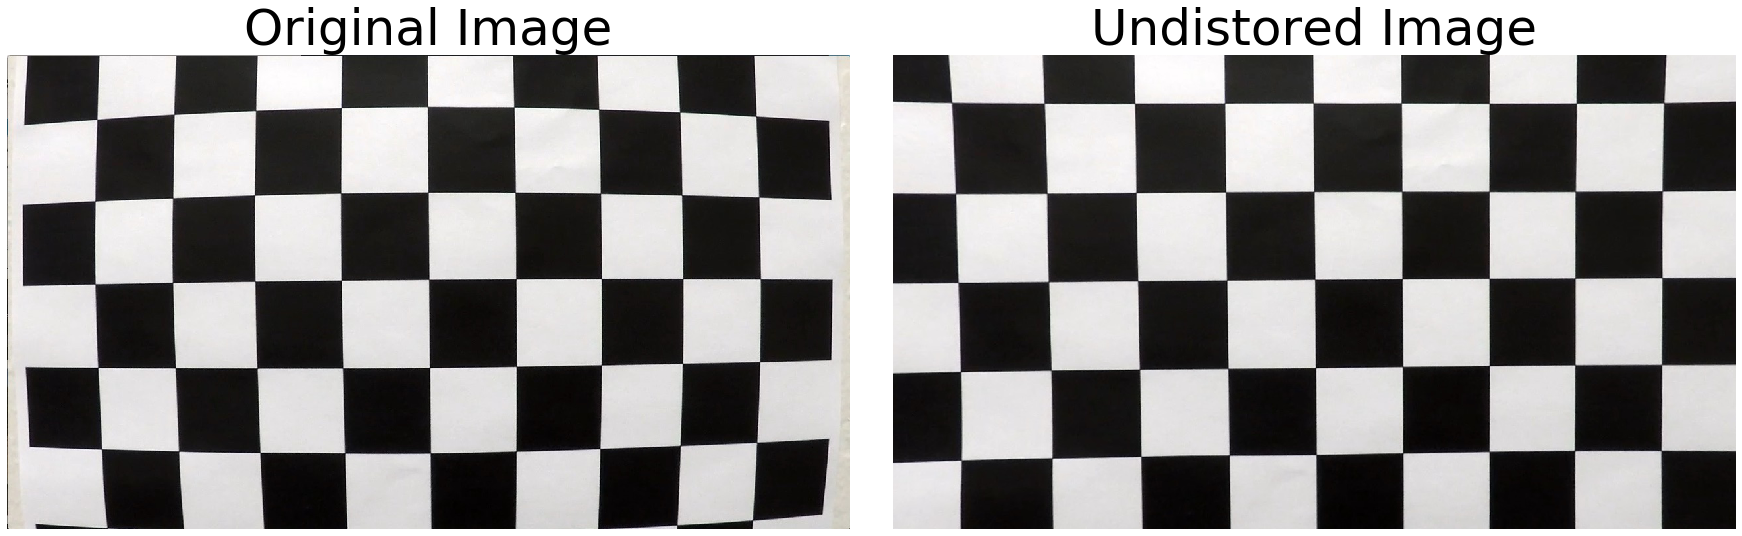

In [14]:
image = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_axis_off()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.set_axis_off()
ax2.imshow(undistorted, cmap='gray')
ax2.set_title('Undistored Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## InteractiveWindow to find x and y coordinates

In [6]:
import cv2
import matplotlib.pyplot as plt



def mousePoints(event,x,y,flags,params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x,y)

#image = mpimg.imread('examples/warped_straight_lines.jpg')

image = mpimg.imread('test_images/straight_lines1.jpg')
undistorted = cal_undistort(image, objpoints, imgpoints)
#imS = cv2.resize(image, (960, 540))  
cv2.imshow('coordinates',undistorted)
cv2.setMouseCallback('coordinates',mousePoints)

cv2.waitKey(0)
cv2.destroyAllWindows()

## Test x and y points on the undistorted image

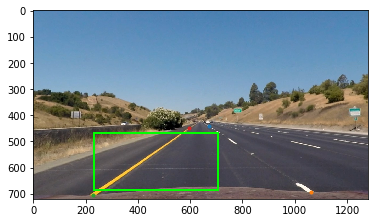

In [9]:
%matplotlib qt

plt.plot(674,442,".")
plt.plot(1062,692,".")
plt.plot(227,704,".")
plt.plot(597,449,".")

# cv2.rectangle(undistorted,(707,467),(231,686),(0,255,0),5)
plt.imshow(undistorted)

## Warp Perspective

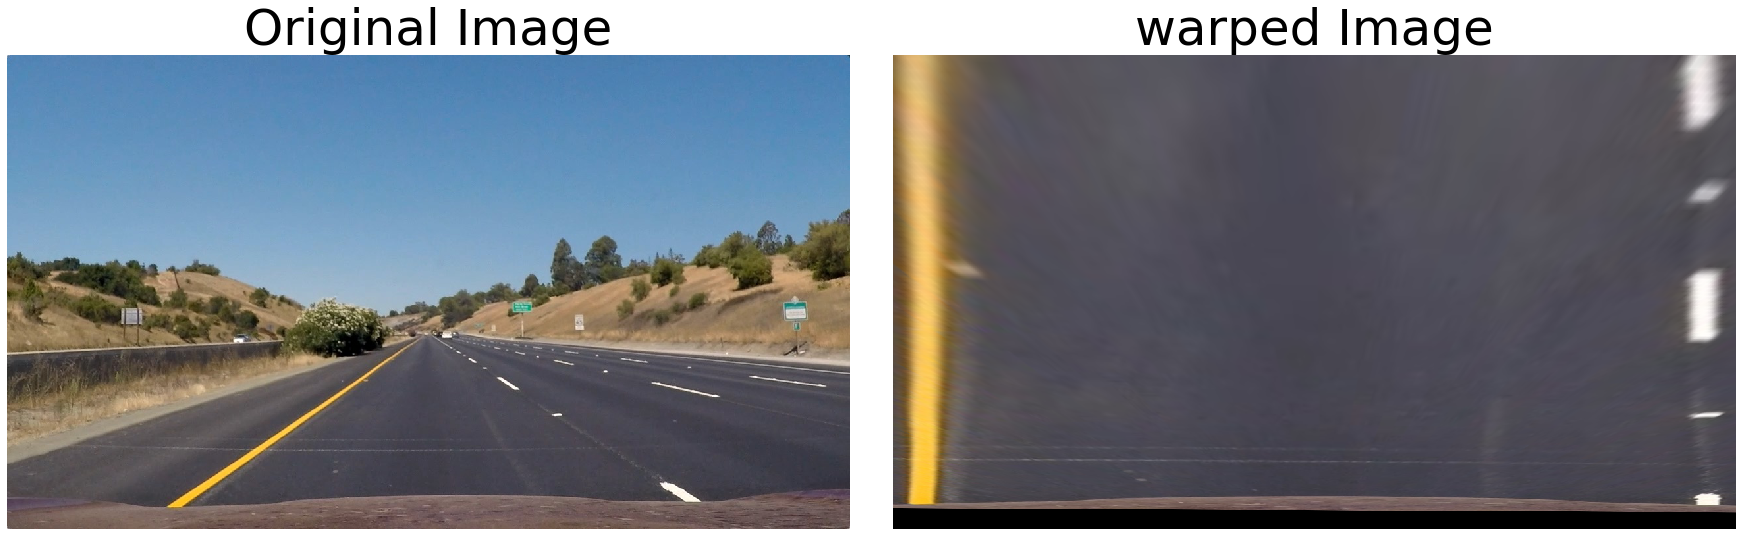

In [8]:
import cv2
import numpy as np
offset = 40 # offset for dst points

image = mpimg.imread('test_images/straight_lines1.jpg')

undistorted = cal_undistort(image, objpoints, imgpoints)
img_size = (undistorted.shape[1], undistorted.shape[0])

src = np.float32(
        [[707,463], #top right
         [1053,686], #bottom right
         [231,701], #bottom left
         [572,467]]) #top left
# src = np.float32(
#         [[674,442], #top right
#          [1062,692], #bottom right
#          [227,704], #bottom left
#          [597,449]]) #top left

dst = np.float32([[img_size[0]-offset, offset], 
                  [img_size[0]-offset, img_size[1]-offset], 
                  [offset, img_size[1]-offset], 
                   [offset, offset]])    
M = cv2.getPerspectiveTransform(src, dst)

Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_axis_off()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.set_axis_off()
ax2.imshow(warped, cmap='gray')
ax2.set_title('warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline on search all through the window

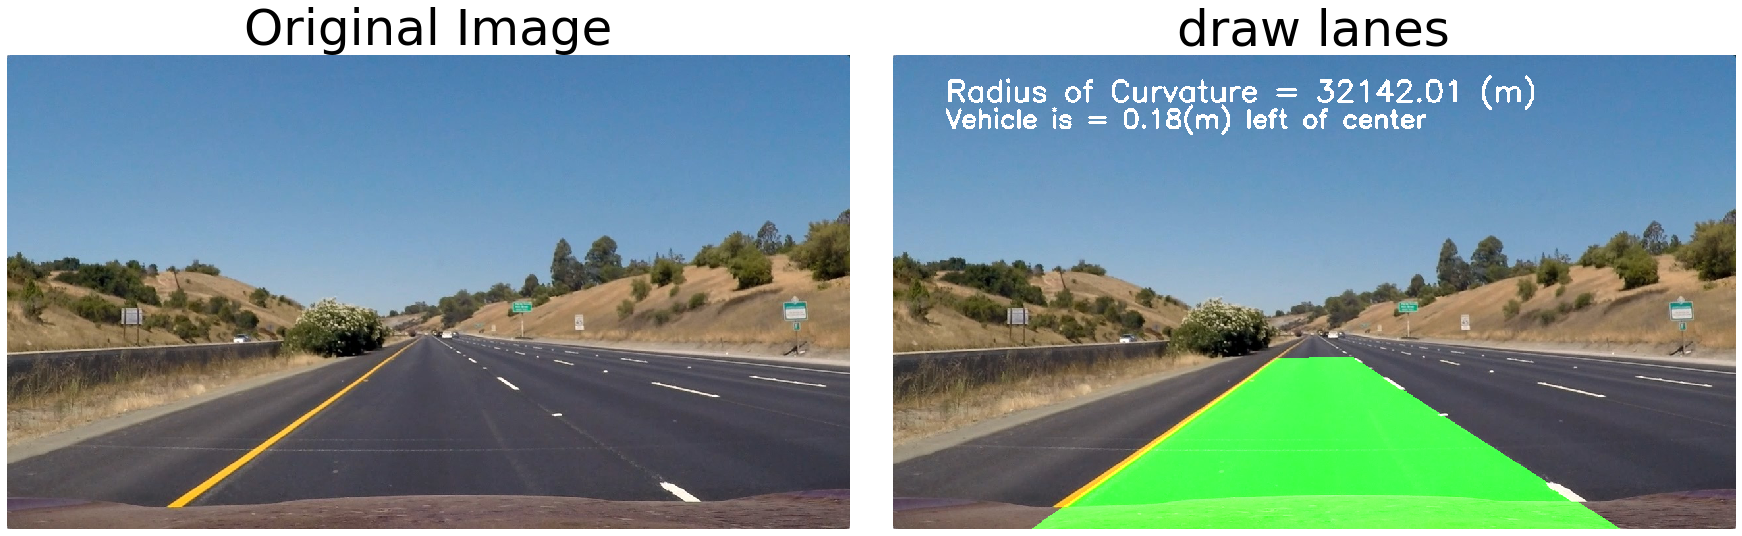

In [15]:
import cv2
import numpy as np
import os
%matplotlib inline


os.listdir("test_images/")
newSearch = True


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
SamCalibImg = glob.glob('camera_cal/calibration*.jpg')

# Find object and image points
findImgpts(SamCalibImg)

image = mpimg.imread('test_images/straight_lines1.jpg')
binary_warped = get_binaryWarped(image)


if Lanetrack.detected == False:
    out_img, left_curve,right_curve,lanes, ploty = fit_polynomial(binary_warped) # use slide panel
else:
    out_img, left_curve,right_curve,lanes, ploty= search_around_poly(binary_warped) # use search poly


left_curverad,right_curverad,curverad, center = get_curvature(image.copy(),left_curve,right_curve)
    
imgFinal = draw_lanes(out_img,image, left_curve, right_curve)

textdisplay(imgFinal,center)
cv2.imwrite('radiusofCurvatureWithLane.jpg',imgFinal)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_axis_off()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.set_axis_off()
ax2.imshow(imgFinal)
ax2.set_title('draw lanes', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
import cv2
import numpy as np
import os
%matplotlib inline

newSearch = True


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
SamCalibImg = glob.glob('camera_cal/calibration*.jpg')

# Find object and image points
findImgpts(SamCalibImg)

def process_image(image):
    binary_warped = get_binaryWarped(image)

    if Lanetrack.detected == False:
        #use sliding panel algorithm
        out_img, left_curve,right_curve,lanes, ploty = fit_polynomial(binary_warped)
    else:
        #use search poly method
        out_img, left_curve,right_curve,lanes, ploty= search_around_poly(binary_warped)

    left_curverad,right_curverad,curverad, center = get_curvature(image.copy(),left_curve,right_curve)

    imgFinal = draw_lanes(out_img,image, left_curve, right_curve)
    textdisplay(imgFinal,center)
    return imgFinal

## Output of project video mp4

In [42]:
white_output = 'test_videos_output/project_video_Final.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(38,42)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                    | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/project_video_Final.mp4.
Moviepy - Writing video test_videos_output/project_video_Final.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video_Final.mp4
Wall time: 29min 10s


## output of harder_challenge_video

In [205]:
white_output = 'test_videos_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,15)
# clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)




                                                                      




                                                                

                                                                         






                                                          





                                                                               
                                                                            



                                                                   


t:   3%|▊                         | 10/325 [5:01:35<07:03,  1.34s/it, now=None]




t:  15%|███▉                      | 49/325 [2:29:38<06:30,  1.41s/it, now=None]

t:   1%|▏                          | 2/325 [5:02:29<03:38,  1.48it/s, now=None]






t:  15%|████                      | 50/325 [2:06:48<06:34,  1.43s/it, now=None]





t:   2%|▍                       | 20/1260 [10:28:32<28:26,  1.38s/it, now=None]



t:   3%|▊                         | 10/325 [4:46:37<06:48,  1.3

Moviepy - Building video test_videos_output/harder_challenge_video.mp4.
Moviepy - Writing video test_videos_output/harder_challenge_video.mp4











t:   1%|▏                            | 2/375 [00:01<04:44,  1.31it/s, now=None]







t:   1%|▏                            | 3/375 [00:02<05:57,  1.04it/s, now=None]







t:   1%|▎                            | 4/375 [00:04<06:43,  1.09s/it, now=None]







t:   1%|▍                            | 5/375 [00:05<07:12,  1.17s/it, now=None]







t:   2%|▍                            | 6/375 [00:07<07:31,  1.22s/it, now=None]







t:   2%|▌                            | 7/375 [00:08<07:43,  1.26s/it, now=None]







t:   2%|▌                            | 8/375 [00:09<07:48,  1.28s/it, now=None]







t:   2%|▋                            | 9/375 [00:11<07:56,  1.30s/it, now=None]







t:   3%|▋                           | 10/375 [00:12<07:57,  1.31s/it, now=None]







t:   3%|▊                           | 11/375 [00:13<07:59,  1.32s/it, now=None]







t:   3%|▉                           | 12/375 [00:15<07:58,  1.32s/it, now=None]







t:   3%|▉                          

t:  39%|██████████▋                | 148/375 [03:20<05:18,  1.40s/it, now=None]







t:  40%|██████████▋                | 149/375 [03:22<05:13,  1.39s/it, now=None]







t:  40%|██████████▊                | 150/375 [03:23<05:09,  1.38s/it, now=None]







t:  40%|██████████▊                | 151/375 [03:24<05:07,  1.37s/it, now=None]







t:  41%|██████████▉                | 152/375 [03:26<05:06,  1.37s/it, now=None]







t:  41%|███████████                | 153/375 [03:27<05:09,  1.39s/it, now=None]







t:  41%|███████████                | 154/375 [03:29<05:06,  1.39s/it, now=None]







t:  41%|███████████▏               | 155/375 [03:30<05:04,  1.38s/it, now=None]







t:  42%|███████████▏               | 156/375 [03:31<05:01,  1.37s/it, now=None]







t:  42%|███████████▎               | 157/375 [03:33<04:56,  1.36s/it, now=None]







t:  42%|███████████▍               | 158/375 [03:34<04:52,  1.35s/it, now=None]







t:  42%|███████████▍               | 159/37

t:  78%|█████████████████████▏     | 294/375 [06:41<01:50,  1.36s/it, now=None]







t:  79%|█████████████████████▏     | 295/375 [06:42<01:48,  1.36s/it, now=None]







t:  79%|█████████████████████▎     | 296/375 [06:43<01:47,  1.36s/it, now=None]







t:  79%|█████████████████████▍     | 297/375 [06:45<01:45,  1.35s/it, now=None]







t:  79%|█████████████████████▍     | 298/375 [06:46<01:44,  1.35s/it, now=None]







t:  80%|█████████████████████▌     | 299/375 [06:47<01:42,  1.35s/it, now=None]







t:  80%|█████████████████████▌     | 300/375 [06:49<01:40,  1.35s/it, now=None]







t:  80%|█████████████████████▋     | 301/375 [06:50<01:40,  1.36s/it, now=None]







t:  81%|█████████████████████▋     | 302/375 [06:51<01:38,  1.35s/it, now=None]







t:  81%|█████████████████████▊     | 303/375 [06:53<01:38,  1.37s/it, now=None]







t:  81%|█████████████████████▉     | 304/375 [06:54<01:36,  1.36s/it, now=None]







t:  81%|█████████████████████▉     | 305/37

Moviepy - Done !
Moviepy - video ready test_videos_output/harder_challenge_video.mp4
Wall time: 8min 36s


## output of challenge_video.mp4

In [211]:
white_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("challenge_video.mp4").subclip(0,15)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)




                                                                      




                                                                

                                                                         






                                                          





                                                                               
                                                                            



                                                                   


t:   3%|▊                         | 10/325 [5:24:36<07:03,  1.34s/it, now=None]




t:  15%|███▉                      | 49/325 [2:52:39<06:30,  1.41s/it, now=None]

t:   1%|▏                          | 2/325 [5:25:30<03:38,  1.48it/s, now=None]






t:  15%|████                      | 50/325 [2:29:49<06:34,  1.43s/it, now=None]





t:   2%|▍                       | 20/1260 [10:51:33<28:26,  1.38s/it, now=None]



t:   3%|▊                         | 10/325 [5:09:38<06:48,  1.3

Moviepy - Building video test_videos_output/challenge_video.mp4.
Moviepy - Writing video test_videos_output/challenge_video.mp4











t:   0%|                             | 2/485 [00:01<05:47,  1.39it/s, now=None]







t:   1%|▏                            | 3/485 [00:02<07:20,  1.09it/s, now=None]







t:   1%|▏                            | 4/485 [00:04<08:31,  1.06s/it, now=None]







t:   1%|▎                            | 5/485 [00:05<09:13,  1.15s/it, now=None]







t:   1%|▎                            | 6/485 [00:06<09:34,  1.20s/it, now=None]







t:   1%|▍                            | 7/485 [00:08<09:49,  1.23s/it, now=None]







t:   2%|▍                            | 8/485 [00:09<09:59,  1.26s/it, now=None]







t:   2%|▌                            | 9/485 [00:10<10:07,  1.28s/it, now=None]







t:   2%|▌                           | 10/485 [00:12<10:13,  1.29s/it, now=None]







t:   2%|▋                           | 11/485 [00:13<10:13,  1.29s/it, now=None]







t:   2%|▋                           | 12/485 [00:14<10:15,  1.30s/it, now=None]







t:   3%|▊                          

t:  31%|████████▏                  | 148/485 [03:16<07:33,  1.35s/it, now=None]







t:  31%|████████▎                  | 149/485 [03:17<07:31,  1.34s/it, now=None]







t:  31%|████████▎                  | 150/485 [03:19<07:31,  1.35s/it, now=None]







t:  31%|████████▍                  | 151/485 [03:20<07:27,  1.34s/it, now=None]







t:  31%|████████▍                  | 152/485 [03:21<07:27,  1.34s/it, now=None]







t:  32%|████████▌                  | 153/485 [03:22<07:23,  1.33s/it, now=None]







t:  32%|████████▌                  | 154/485 [03:24<07:22,  1.34s/it, now=None]







t:  32%|████████▋                  | 155/485 [03:25<07:21,  1.34s/it, now=None]







t:  32%|████████▋                  | 156/485 [03:27<07:21,  1.34s/it, now=None]







t:  32%|████████▋                  | 157/485 [03:28<07:19,  1.34s/it, now=None]







t:  33%|████████▊                  | 158/485 [03:29<07:17,  1.34s/it, now=None]







t:  33%|████████▊                  | 159/48

TypeError: expected non-empty vector for x